# Model with real data

In [1]:
!pip install ema_workbench
from ema_workbench import (perform_experiments, ema_logging)
ema_logging.log_to_stderr(ema_logging.INFO)

import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 kB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/ema_workbench/em_framework/evaluators.py:58: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [2]:
from ema_workbench import (Model, RealParameter, IntegerParameter, ScalarOutcome, SequentialEvaluator, Policy, perform_experiments, Scenario)
from ema_workbench import MultiprocessingEvaluator, Samplers
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from numpy.random import RandomState
import math

# Fare prices based on the number of units
fare_structure = {
    i: 2.6 + 0.015 * (i-1) for i in range(1, 201)
}

trains_2022 = 761
capacity_2022 = 245266
average_seats_per_train = math.ceil(capacity_2022 / trains_2022)

def calculate_fare_price(trips, km):
    # Calculate the average distance per trip
    avg_distance_per_trip = km / trips

    # 1 km is approximately 1 fare unit
    fare_units_per_trip = math.ceil(avg_distance_per_trip)
    # print(avg_distance_per_trip)

    # Get the fare price for the corresponding number of fare units
    fare_price = fare_structure.get(fare_units_per_trip, max(fare_structure.values()))
    # print(fare_price)

    return fare_price

def calculate_demand(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students, pop, students, international_students, traffic_participation):
    fare_price = calculate_fare_price(trips, km)

    # Calculate the population that are Dutch students, international students, and non-students
    dutch_students = (students - international_students)
    international_students = international_students
    non_students = (pop - students)

    # Convert usage percentage for week and weekend ov students to real usage percentage
    week_ov_real = week_ov / (5/7)
    weekend_ov_real = weekend_ov / (2/7)

    # Convert traffic_participation to percentage
    traffic_participation = traffic_participation / 100

    # Calculate the average usage rate for Dutch students, international students, and non-students
    avg_dutch_students_usage = ((week_ov_real + weekend_ov_real) / 2) / 100
    avg_international_students_usage = non_ov / 100
    avg_non_students_usage = non_ov / 100

    # Calculate the demand for each group
    demand_dutch_students = dutch_students * avg_dutch_students_usage #* (1 - free_transit)
    demand_international_students = international_students * ((avg_international_students_usage * (1 - free_transit_students)) + (avg_dutch_students_usage * free_transit_students))
    demand_non_students = non_students * ((avg_non_students_usage * (1 - free_transit)) + (avg_dutch_students_usage * free_transit * traffic_participation))

    # Total demand is the sum of the demand for each group
    total_daily_demand = demand_dutch_students + demand_international_students + demand_non_students

    # Calculate revenue
    revenue = fare_price * trips * ((demand_international_students * (1 - free_transit_students)) + (demand_non_students * (1 - free_transit)))

    return total_daily_demand, revenue

def calculate_emissions(pop, demand, km, car_trips_per_person_per_day, distance_per_car_trip, car_C02_emissions):
    # Calculate the average car trips per person per day
    avg_car_trips_per_day = car_trips_per_person_per_day * pop

    # Calculate the total distance travelled by cars
    total_car_distance = avg_car_trips_per_day * distance_per_car_trip

    # Calculate emissions per km
    avg_CO2_emissions_per_km = car_C02_emissions / total_car_distance

    # # Calculate the total CO2 emissions from cars
    # total_car_CO2_emissions = total_car_distance * avg_CO2_emissions_per_km

    # Assume that each train trip replaces one car trip
    # Calculating what the emissions would be if everyone drove instead of taking the train
    CO2_reduction = demand * (km * avg_CO2_emissions_per_km)

    # The net CO2 emissions are the emissions from cars minus the reduction from train trips
    net_CO2_emissions = car_C02_emissions - (demand * (distance_per_car_trip * avg_CO2_emissions_per_km))

    return CO2_reduction, net_CO2_emissions

# Define the model
def rail_model(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students, pop, students, international_students, traffic_participation, capacity, car_trips_per_person_per_day, distance_per_car_trip, car_C02_emissions):
    daily_demand , revenue = calculate_demand(trips, km, week_ov, weekend_ov, non_ov,
                                              free_transit, free_transit_students, pop,
                                              students, international_students, traffic_participation)

    # Assume, on average, that 75% of people will make two trips
    # daily_demand = daily_demand * 1.5

    # Assume a train makes 10 rounds in a day
    rounds_per_day = 10

    # Calculate the total capacity in a day
    total_capacity = capacity * rounds_per_day

    # Check if the capacity is sufficient for the daily demand
    if daily_demand > total_capacity:
        # If not, calculate the shortage
        shortage = daily_demand - total_capacity
    else:
        # If it is, there's no shortage
        shortage = 0

    # Calculate the number of additional trains needed
    additional_trains = math.ceil(shortage / (average_seats_per_train * rounds_per_day))

    CO2_reduction, net_CO2_emissions = calculate_emissions(pop, daily_demand, km, car_trips_per_person_per_day, distance_per_car_trip, car_C02_emissions)


    return {'demand': daily_demand, 'revenue': revenue, 'shortage': shortage, 'additional_trains': additional_trains, 'CO2_reduction': CO2_reduction, 'net_CO2_emissions': net_CO2_emissions}

model_rail = Model('RailDemand', function=rail_model)

# Define the uncertainties and levers
model_rail.uncertainties = [RealParameter('trips', 27, 30),
                            RealParameter('km', 1335, 1499),
                            RealParameter('week_ov', 38.7, 42.9),
                            RealParameter('weekend_ov', 12.7, 22.8),
                            RealParameter('non_ov', 6.9, 7.4),
                            RealParameter('pop', 17181084, 17590672),
                            RealParameter('students', 292600, 292600),  # Assuming no change in students
                            RealParameter('international_students', 83817, 83817), # Assuming no change in international students
                            RealParameter('traffic_participation', 82.2, 83.1),
                            RealParameter('car_trips_per_person_per_day', 0.94, 0.97),
                            RealParameter('distance_per_car_trip', 17.76, 18.85),

                            RealParameter('car_C02_emissions', 14900, 18000)]

model_rail.levers = [IntegerParameter('free_transit', 0, 1),
                     IntegerParameter('free_transit_students', 0, 1),
                     RealParameter('capacity', 245266, 245276)]

model_rail.outcomes = [ScalarOutcome('demand'), ScalarOutcome('revenue'),
                       ScalarOutcome('shortage'), ScalarOutcome('additional_trains'),
                       ScalarOutcome('CO2_reduction'), ScalarOutcome('net_CO2_emissions')]

# Define the baseline scenario
# baseline_scenario = {'trips': 28.5, 'km': 1417, 'week_ov': 40.8, 'weekend_ov': 17.75, 'non_ov': 7.15,
#                      'pop': 17375617, 'students': 292600, 'international_students': 83817, 'free_transit': 0}

# Define the baseline scenario
baseline_scenario = [Scenario("baseline", **{
    'trips': 28.5,
    'km': 1417,
    'week_ov': 40.8,
    'weekend_ov': 17.75,
    'non_ov': 7.15,
    'pop': 17375617,
    'students': 292600,
    'international_students': 83817,
    'free_transit': 0,
    'free_transit_students': 0,
    'capacity': 245266,
    'traffic_participation': 82.6,
    'car_trips_per_person_per_day': 0.96,
    'distance_per_car_trip': 18.16,
    'car_C02_emissions': 17600})]

policies = 512

# Running experiments
with MultiprocessingEvaluator(model_rail) as evaluator:
    results = evaluator.perform_experiments(scenarios=baseline_scenario, policies=policies,
                                            uncertainty_sampling=Samplers.SOBOL)

# results[0]


[MainProcess/INFO] pool started with 2 workers
[MainProcess/INFO] performing 1 scenarios * 512 policies * 1 model(s) = 512 experiments
100%|███████████████████████████████████████| 512/512 [00:00<00:00, 628.75it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


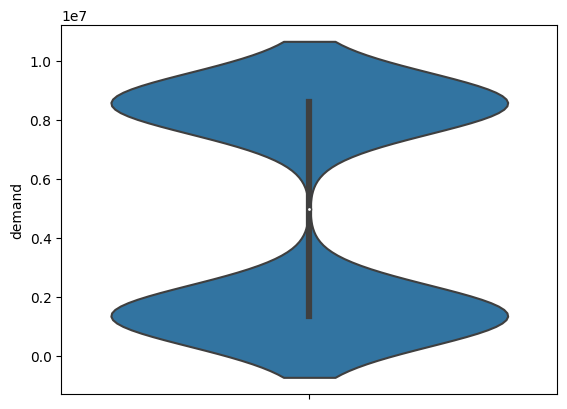

In [3]:
# Plot results
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

experiments, outcomes = results
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(data=data, y='demand')
plt.show()

# sns.violinplot(data=data, y='revenue')
# plt.show()

# sns.violinplot(data=data, y='shortage')
# plt.show()

# sns.violinplot(data=data, y='additional_trains')
# plt.show()

In [4]:
from ema_workbench import (Model, RealParameter, ScalarOutcome, SequentialEvaluator, Policy, perform_experiments)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench import MultiprocessingEvaluator, Samplers
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from numpy.random import RandomState
import math

model_rail.outcomes = [ScalarOutcome('demand', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('revenue', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('shortage', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('additional_trains', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('CO2_reduction', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('net_CO2_emissions', kind=ScalarOutcome.MINIMIZE)]

# Optimize
convergence_metrics = [EpsilonProgress()]

epsilons = [.005, .005, .005, .005, .005, .005]

with MultiprocessingEvaluator(model_rail) as evaluator:
    results, convergence = evaluator.optimize(nfe=5000, searchover='levers', epsilons=epsilons, reference=baseline_scenario[0],
                                              convergence=convergence_metrics)

results


[MainProcess/INFO] pool started with 2 workers
100%|█████████████████████████████████████| 5000/5000 [00:15<00:00, 326.41it/s]
[MainProcess/INFO] optimization completed, found 4 solutions
[MainProcess/INFO] terminating pool


,free_transit,free_transit_students,capacity,demand,revenue,shortage,additional_trains,CO2_reduction,net_CO2_emissions
0,0,0,245274.248681,1.351910e+06,1.166640e+08,0.000000e+00,0,111302.027247,16173.574584
1,0,1,245266.817797,1.395891e+06,1.160944e+08,0.000000e+00,0,114922.948453,16127.169553
2,1,1,245275.986713,8.587531e+06,0.000000e+00,6.134771e+06,1900,707006.711026,8539.137705
3,1,0,245276.000000,8.543550e+06,5.696116e+05,6.090790e+06,1886,703385.789820,8585.542736


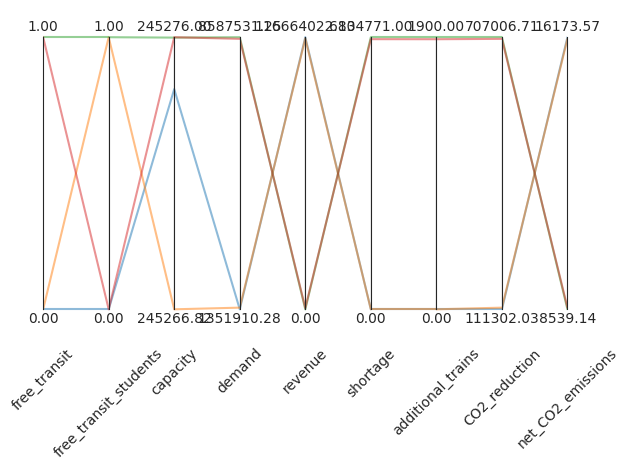

In [5]:
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt

results

limits = parcoords.get_limits(results)
axes = parcoords.ParallelAxes(limits, fontsize=10, rot=45)
axes.plot(results, alpha=0.5)

# we invert this axis so direction of desirability is the same
#axes.invert_axis('max_P')
# plt.savefig(f".\output\directed_search\Directed_Search_{case}_{experiment_number}_paracord_scores.svg", dpi=600, bbox_inches='tight')
# plt.savefig(f".\output\directed_search\Directed_Search_{case}_{experiment_number}_paracord_scores.png", dpi=600, bbox_inches='tight')
plt.show()

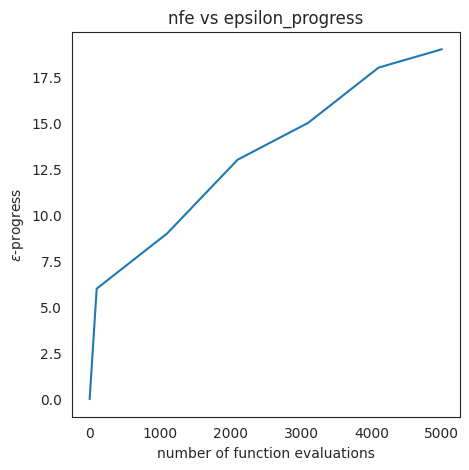

In [6]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(ncols=1, sharex=True, figsize=(5,5))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
#ax2.plot(convergence.nfe, convergence.hypervolume)
#ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
#ax2.set_xlabel('number of function evaluations')

# ax1.legend()
ax1.set_title(f"nfe vs epsilon_progress")

# fig.savefig(f".\output\directed_search\Directed_Search_{case}_{experiment_number}_epsilon_progress.svg", dpi=600, bbox_inches='tight')
# fig.savefig(f".\output\directed_search\Directed_Search_{case}_{experiment_number}_epsilon_progress.png", dpi=600, bbox_inches='tight')
fig.show()

<ipython-input-7-a47c41dc8dd2>:32: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
<ipython-input-7-a47c41dc8dd2>:32: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
<ipython-input-7-a47c41dc8dd2>:32: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
<ipython-input-7-a47c41dc8dd2>:32: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a f

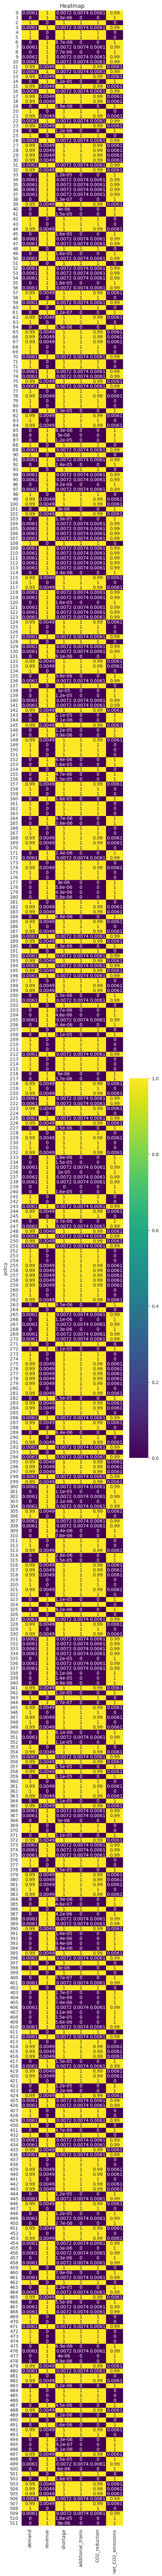

In [7]:
import numpy as np
def calculate_regret(data, best):
    return np.abs(best-data)


overall_regret = {}
max_regret = {}
for outcome in model_rail.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()


max_regret = pd.DataFrame(max_regret)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,100),
                       sharey=True, sharex=True)
ax.set_title("Heatmap")
sns.heatmap(max_regret/max_regret.max(), cmap='viridis',annot=True, ax=ax)

# plt.savefig(f".\output\directed_search\Directed_Search_{case}_{experiment_number}_heatmap.svg", dpi=600, bbox_inches='tight')
# plt.savefig(f".\output\directed_search\Directed_Search_{case}_{experiment_number}_heatmap.png", dpi=600, bbox_inches='tight')

plt.show()

In [8]:
# I'm going to add a new function to calculate elasticity to your model
# This function uses your calculate_demand function to calculate new and old demand
# based on a change in price (fare). Then, it calculates elasticity based on those values.

# Fare prices based on the number of units
fare_structure = {
    i: 2.6 + 0.015 * (i-1) for i in range(1, 201)
}

trains_2022 = 761
capacity_2022 = 245266
average_seats_per_train = math.ceil(capacity_2022 / trains_2022)

def calculate_fare_price(trips, km):
    # Calculate the average distance per trip
    avg_distance_per_trip = km / trips

    # 1 km is approximately 1 fare unit
    fare_units_per_trip = math.ceil(avg_distance_per_trip)
    # print(avg_distance_per_trip)

    # Get the fare price for the corresponding number of fare units
    fare_price = fare_structure.get(fare_units_per_trip, max(fare_structure.values()))
    # print(fare_price)

    return fare_price

def calculate_elasticity(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students, pop, students, international_students, traffic_participation, capacity, car_trips_per_person_per_day, distance_per_car_trip, car_C02_emissions, price_increase):
    # Calculate the old fare price
    old_fare_price = calculate_fare_price(trips, km)

    # Step 2: Calculate the new fare price based on this percentage change
    new_fare_price = old_fare_price * (1 + price_increase)

    fare_structure = {
    i: 2.6 + 0.015 * (i-1) for i in range(1, 201)
    }

    # Save the old fare_structure
    old_fare_structure = fare_structure.copy()

    # Update the fare_structure to reflect the new fare price
    for i in range(1, 201):
        fare_structure[i] = new_fare_price + 0.015 * (i-1)

    # Step 3: Calculate the new demand based on the new fare price
    new_daily_demand, new_revenue = calculate_demand(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students, pop, students, international_students, traffic_participation)

    # Restore the old fare_structure
    fare_structure = old_fare_structure

    # Calculate the old demand
    old_daily_demand , old_revenue = calculate_demand(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students, pop, students, international_students, traffic_participation)

    # Step 4: Calculate the percentage change in demand and the percentage change in price
    pct_change_demand = (new_daily_demand - old_daily_demand) / old_daily_demand
    pct_change_price = (new_fare_price - old_fare_price) / old_fare_price

    # Step 5: Calculate the elasticity as the ratio of the percentage change in demand to the percentage change in price
    elasticity = pct_change_demand / pct_change_price

    return elasticity

# Add the price_increase lever to your model
model_rail.levers += [RealParameter('price_increase', 0, 0.5)]

# Add the elasticity outcome to your model
# model_rail.outcomes += [ScalarOutcome('elasticity')]

# Update your model function to include the elasticity calculation
def rail_model(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students, pop, students, international_students, traffic_participation, capacity, car_trips_per_person_per_day, distance_per_car_trip, car_C02_emissions, price_increase):
    daily_demand , revenue = calculate_demand(trips, km, week_ov, weekend_ov, non_ov,
                                              free_transit, free_transit_students, pop,
                                              students, international_students, traffic_participation)

    rounds_per_day = 10
    total_capacity = capacity * rounds_per_day
    if daily_demand > total_capacity:
        shortage = daily_demand - total_capacity
    else:
        shortage = 0
    additional_trains = math.ceil(shortage / (average_seats_per_train * rounds_per_day))

    CO2_reduction, net_CO2_emissions = calculate_emissions(pop, daily_demand, km, car_trips_per_person_per_day, distance_per_car_trip, car_C02_emissions)

    elasticity = calculate_elasticity(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students, pop, students, international_students, traffic_participation, capacity, car_trips_per_person_per_day, distance_per_car_trip, car_C02_emissions, price_increase)

    return {'demand': daily_demand, 'revenue': revenue, 'shortage': shortage, 'additional_trains': additional_trains, 'CO2_reduction': CO2_reduction, 'net_CO2_emissions': net_CO2_emissions, 'elasticity': elasticity}

model_rail.function = rail_model

# # Check the model's levers and outcomes
# model_rail.levers, model_rail.outcomes

# with MultiprocessingEvaluator(model_rail) as evaluator:
#     results = evaluator.perform_experiments(scenarios=baseline_scenario, policies=policies,
#                                             uncertainty_sampling=Samplers.SOBOL)
# results[0]

model_rail.outcomes = [ScalarOutcome('demand', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('revenue', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('shortage', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('additional_trains', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('CO2_reduction', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('net_CO2_emissions', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('elasticity', kind=ScalarOutcome.MINIMIZE)]

# Optimize
convergence_metrics = [EpsilonProgress()]

epsilons = [.005, .005, .005, .005, .005, .005, .005]

with MultiprocessingEvaluator(model_rail) as evaluator:
    results, convergence = evaluator.optimize(nfe=5000, searchover='levers', epsilons=epsilons, reference=baseline_scenario[0],
                                              convergence=convergence_metrics)

results


[MainProcess/INFO] pool started with 2 workers
100%|█████████████████████████████████████| 5000/5000 [00:10<00:00, 495.90it/s]
[MainProcess/INFO] optimization completed, found 4 solutions
[MainProcess/INFO] terminating pool


,free_transit,free_transit_students,capacity,price_increase,demand,revenue,shortage,additional_trains,CO2_reduction,net_CO2_emissions,elasticity
0,0,1,245266.819905,0.445268,1.395891e+06,1.160944e+08,0,0,114922.948453,16127.169553,0.0
1,0,0,245272.777644,0.310225,1.351910e+06,1.166640e+08,0,0,111302.027247,16173.574584,0.0
2,1,0,245275.969203,0.468097,8.543550e+06,5.696116e+05,6090790,1886,703385.789820,8585.542736,0.0
3,1,1,245276.000000,0.412761,8.587531e+06,0.000000e+00,6134771,1900,707006.711026,8539.137705,0.0


In [9]:
import pandas as pd

# Extracted numerical datapoints
data = {
    "Year": [1985, 1991, 1995, 2012],
    "Total Product Growth (%)": [None, None, None, 70],
    "Average Annual Growth (%)": [None, None, None, 2.0],
    "Passenger Kilometers (billion)": [8.7, None, None, 17.1],
    "Trend 1985-1994": [-0.049, None, None, None],
    "Trend 1995-2004": [None, None, 0.018, None],
    "Trend 2005-2012": [None, None, None, 0.004],
    "Price Personnel": [0.577, None, None, None],
    "Price Material": [0.317, None, None, None],
    "Price Capital": [0.106, None, None, None],
    "Trend x Price Personnel": [-0.013, None, None, None],
    "Trend x Price Material": [0.008, None, None, None],
    "Trend x Price Capital": [0.005, None, None, None],
    "AR-coefficient": [0.486, None, None, None],
    "BG Cost Share Personnel": [0.155, None, None, None],
    "BG Cost Share Material": [0.002, None, None, None],
    "BG Cost Share Capital": [2.932, None, None, None]
}

df = pd.DataFrame(data)

# Interpolate missing data
df.interpolate(method='linear', inplace=True)

df


,Year,Total Product Growth (%),Average Annual Growth (%),Passenger Kilometers (billion),Trend 1985-1994,Trend 1995-2004,Trend 2005-2012,Price Personnel,Price Material,Price Capital,Trend x Price Personnel,Trend x Price Material,Trend x Price Capital,AR-coefficient,BG Cost Share Personnel,BG Cost Share Material,BG Cost Share Capital
0,1985,NaN,NaN,8.7,-0.049,NaN,NaN,0.577,0.317,0.106,-0.013,0.008,0.005,0.486,0.155,0.002,2.932
1,1991,NaN,NaN,11.5,-0.049,NaN,NaN,0.577,0.317,0.106,-0.013,0.008,0.005,0.486,0.155,0.002,2.932
2,1995,NaN,NaN,14.3,-0.049,0.018,NaN,0.577,0.317,0.106,-0.013,0.008,0.005,0.486,0.155,0.002,2.932
3,2012,70.0,2.0,17.1,-0.049,0.018,0.004,0.577,0.317,0.106,-0.013,0.008,0.005,0.486,0.155,0.002,2.932


In [10]:
from ema_workbench import (Model, RealParameter, IntegerParameter, ScalarOutcome, SequentialEvaluator, Policy, perform_experiments, Scenario)
from ema_workbench import MultiprocessingEvaluator, Samplers
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from numpy.random import RandomState
import math

# Fare prices based on the number of units
fare_structure = {
    i: 2.6 + 0.015 * (i-1) for i in range(1, 201)
}

trains_2022 = 761
capacity_2022 = 245266
average_seats_per_train = math.ceil(capacity_2022 / trains_2022)

def calculate_fare_price(trips, km):
    # Calculate the average distance per trip
    avg_distance_per_trip = km / trips

    # 1 km is approximately 1 fare unit
    fare_units_per_trip = math.ceil(avg_distance_per_trip)

    # Get the fare price for the corresponding number of fare units
    fare_price = fare_structure.get(fare_units_per_trip, max(fare_structure.values()))

    return fare_price

def calculate_demand(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students, pop, students, international_students, traffic_participation):
    fare_price = calculate_fare_price(trips, km)

    # Calculate the population that are Dutch students, international students, and non-students
    dutch_students = (students - international_students)
    international_students = international_students
    non_students = (pop - students)

    # Convert usage percentage for week and weekend ov students to real usage percentage
    week_ov_real = week_ov / (5/7)
    weekend_ov_real = weekend_ov / (2/7)

    # Convert traffic_participation to percentage
    traffic_participation = traffic_participation / 100

    # Calculate the average usage rate for Dutch students, international students, and non-students
    avg_dutch_students_usage = ((week_ov_real + weekend_ov_real) / 2) / 100
    avg_international_students_usage = non_ov / 100
    avg_non_students_usage = non_ov / 100

    # Calculate the demand for each group
    demand_dutch_students = dutch_students * avg_dutch_students_usage
    demand_international_students = international_students * ((avg_international_students_usage * (1 - free_transit_students)) + (avg_dutch_students_usage * free_transit_students))
    demand_non_students = non_students * ((avg_non_students_usage * (1 - free_transit)) + (avg_dutch_students_usage * free_transit * traffic_participation))

    # Total demand is the sum of the demand for each group
    total_daily_demand = demand_dutch_students + demand_international_students + demand_non_students

    # Calculate revenue
    revenue = fare_price * trips * ((demand_international_students * (1 - free_transit_students)) + (demand_non_students * (1 - free_transit)))

    return total_daily_demand, revenue

def calculate_emissions(pop, demand, km, car_trips_per_person_per_day, distance_per_car_trip, car_C02_emissions):
    # Calculate the average car trips per person per day
    avg_car_trips_per_day = car_trips_per_person_per_day * pop

    # Calculate the total distance travelled by cars
    total_car_distance = avg_car_trips_per_day * distance_per_car_trip

    # Calculate emissions per km
    avg_CO2_emissions_per_km = car_C02_emissions / total_car_distance

    # Calculate the CO2 reduction due to train usage
    CO2_reduction = demand * (km * avg_CO2_emissions_per_km)

    # Calculate net CO2 emissions considering car and train usage
    net_CO2_emissions = car_C02_emissions - (demand * (distance_per_car_trip * avg_CO2_emissions_per_km))

    return CO2_reduction, net_CO2_emissions

# Define the model
def rail_model(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students, pop,
               students, international_students, traffic_participation, capacity,
               car_trips_per_person_per_day, distance_per_car_trip, car_C02_emissions):
    daily_demand, revenue = calculate_demand(trips, km, week_ov, weekend_ov, non_ov,
                                             free_transit, free_transit_students, pop,
                                             students, international_students, traffic_participation)

    # Assume a train makes 10 rounds in a day
    rounds_per_day = 10

    # Calculate the total capacity in a day
    total_capacity = capacity * rounds_per_day

    # Check if the capacity is sufficient for the daily demand
    if daily_demand > total_capacity:
        # If not, calculate the shortage
        shortage = daily_demand - total_capacity
    else:
        # If it is, there's no shortage
        shortage = 0

    # Calculate the number of additional trains needed
    additional_trains = math.ceil(shortage / (average_seats_per_train * rounds_per_day))

    CO2_reduction, net_CO2_emissions = calculate_emissions(pop, daily_demand, km, car_trips_per_person_per_day, distance_per_car_trip, car_C02_emissions)

    return {'demand': daily_demand, 'revenue': revenue, 'shortage': shortage,
            'additional_trains': additional_trains, 'CO2_reduction': CO2_reduction,
            'net_CO2_emissions': net_CO2_emissions}

model_rail = Model('RailDemand', function=rail_model)

# Define the uncertainties and levers
model_rail.uncertainties = [RealParameter('trips', 27, 30),
                            RealParameter('km', 1335, 1499),
                            RealParameter('week_ov', 38.7, 42.9),
                            RealParameter('weekend_ov', 12.7, 22.8),
                            RealParameter('non_ov', 6.9, 7.4),
                            RealParameter('pop', 16655799, 17475415), # Change in population from 2011 to 2021
                            RealParameter('students', 585180, 754650),  # Change in students from 2011 to 2021
                            RealParameter('international_students', 53720, 115190), # Change in international students from 2011 to 2021
                            RealParameter('traffic_participation', 82.2, 83.1),
                            RealParameter('car_trips_per_person_per_day', 0.94, 0.97),
                            RealParameter('distance_per_car_trip', 17.76, 18.85),
                            RealParameter('car_C02_emissions', 14900, 18000)]

model_rail.levers = [IntegerParameter('free_transit', 0, 1),
                     IntegerParameter('free_transit_students', 0, 1),
                     RealParameter('capacity', 245266, 245276)]

model_rail.outcomes = [ScalarOutcome('demand'), ScalarOutcome('revenue'),
                       ScalarOutcome('shortage'), ScalarOutcome('additional_trains'),
                       ScalarOutcome('CO2_reduction'), ScalarOutcome('net_CO2_emissions')]

# Define baseline values for explanatory variables
baseline_students = 292600
baseline_population = 17375617
# Add other baseline values...

# Define the baseline scenario
baseline_scenario = [Scenario("baseline", **{
    'trips': 28.5,
    'km': 1417,
    'week_ov': 40.8,
    'weekend_ov': 17.75,
    'non_ov': 7.15,
    'pop': 17375617,
    'students': 292600,
    'international_students': 83817,
    'free_transit': 0,
    'free_transit_students': 0,
    'capacity': 245266,
    'traffic_participation': 82.6,
    'car_trips_per_person_per_day': 0.96,
    'distance_per_car_trip': 18.16,
    'car_C02_emissions': 17600})]

policies = 512

# Running experiments
with MultiprocessingEvaluator(model_rail) as evaluator:
    results = evaluator.perform_experiments(scenarios=baseline_scenario, policies=policies,
                                            uncertainty_sampling=Samplers.SOBOL)

results[0]


[MainProcess/INFO] pool started with 2 workers
[MainProcess/INFO] performing 1 scenarios * 512 policies * 1 model(s) = 512 experiments
100%|██████████████████████████████████████| 512/512 [00:00<00:00, 1418.48it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


,trips,km,week_ov,weekend_ov,non_ov,pop,students,international_students,traffic_participation,car_trips_per_person_per_day,distance_per_car_trip,car_C02_emissions,capacity,free_transit,free_transit_students,scenario,policy,model
0,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,245274.988445,1,1,baseline,512,RailDemand
1,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,245267.281240,1,1,baseline,513,RailDemand
2,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,245271.482908,0,1,baseline,514,RailDemand
3,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,245272.658821,1,0,baseline,515,RailDemand
4,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,245266.776656,1,0,baseline,516,RailDemand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,245273.069633,0,1,baseline,1019,RailDemand
508,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,245266.732032,0,0,baseline,1020,RailDemand
509,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,245272.440715,0,1,baseline,1021,RailDemand
510,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,245266.144050,0,1,baseline,1022,RailDemand


In [11]:
from ema_workbench import (Model, RealParameter, IntegerParameter, ScalarOutcome, Scenario,
                           MultiprocessingEvaluator, Samplers)

# Define fare structure, functions, baseline fare, and test parameters again


baseline_fare = fare_structure[100]  # Using the fare for 1 unit as the baseline

# Elasticity for train fare
fare_elasticity = -0.63
student_elasticity = 0.23
resident_elasticity = 1.38

# Baseline values for students and residents
baseline_students = 683350
baseline_residents = 17181084

def calculate_fare_price_with_elasticity(trips, km, price_per_km):
    # Calculate the average distance per trip
    avg_distance_per_trip = km / trips

    # 1 km is approximately 1 fare unit
    fare_units_per_trip = math.ceil(avg_distance_per_trip)


    fare_structure = {
    i: 2.6 + price_per_km * (i-1) for i in range(1, 201)
    }

    # Get the fare price for the corresponding number of fare units
    fare_price = fare_structure.get(fare_units_per_trip, max(fare_structure.values()))

    baseline_fare = 15 #fare_structure[math.ceil(trips / km)]

    return fare_price, baseline_fare

# def sigmoid_elasticity(price_per_km, L=-0.63, k=1, x0=0.2):
#     """
#     Returns the elasticity value based on the price change percentage using a sigmoid function.

#     Parameters:
#     - price_per_km: The price per km
#     - L: The maximum absolute value of elasticity.
#     - k: The steepness of the sigmoid curve.
#     - x0: The price per km where the maximum rate of change in elasticity happens.

#     Returns:
#     - Elasticity value.
#     """

#     return (2*L) / (1 + np.exp(-k * (price_per_km - x0)))

# # Test the function
# price_changes = [0.02, 0.07, 0.1, 0.2]
# elasticities = [get_elasticity(x) for x in price_changes]
# elasticities


def calculate_demand_with_elasticity(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students,
                                     pop, students, international_students, traffic_participation, price_per_km):

    # Set price_per_km to zero when the free_transit policy lever is active
    price_per_km = price_per_km * (1 - free_transit)

    fare_price, baseline_fare = calculate_fare_price_with_elasticity(trips, km, price_per_km)

    # Calculate percentage change in price compared to the baseline
    price_change_percentage = (fare_price - baseline_fare) / baseline_fare

    # Use elasticity to determine percentage change in demand
    # demand_change_percentage = sigmoid_elasticity(price_per_km) * price_change_percentage
    demand_change_percentage_price = fare_elasticity * price_change_percentage

    # Calculate percentage change in students and residents from their baseline values
    student_change_percentage = (students - baseline_students) / baseline_students
    resident_change_percentage = (pop - baseline_residents) / baseline_residents

    # Use elasticity to determine percentage change in demand due to student and resident changes
    demand_change_percentage_student = student_elasticity * student_change_percentage
    demand_change_percentage_resident = resident_elasticity * resident_change_percentage

    # Calculate original demand without considering elasticity
    daily_demand, revenue = calculate_demand(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students,
                                             pop, students, international_students, traffic_participation)

    # Adjust the demand based on all elasticity values
    adjusted_demand = daily_demand * (1 + demand_change_percentage_price +
                                      demand_change_percentage_student +
                                      demand_change_percentage_resident)

    if price_per_km == 0:
        revenue = 0

    adjusted_revenue = revenue * (1 + demand_change_percentage_price +
                                      demand_change_percentage_student +
                                      demand_change_percentage_resident)

    adjusted_demand = max(adjusted_demand, 0)
    adjusted_revenue = max(adjusted_revenue, 0)


    # Calculate revenue
    # revenue = max(revenue * (1 + demand_change_percentage), 0)
    # revenue = fare_price * trips * ((adjusted_demand * (1 - free_transit_students)) +
    #                                 (adjusted_demand * (1 - free_transit)))


    return adjusted_demand, adjusted_revenue

# Modify the rail_model_with_elasticity function to accept baseline_fare as a parameter
def rail_model_with_elasticity(trips, km, week_ov, weekend_ov, non_ov, free_transit, free_transit_students,
                               pop, students, international_students, traffic_participation, capacity,
                               car_trips_per_person_per_day, distance_per_car_trip, car_C02_emissions,
                               price_per_km):

    daily_demand, revenue = calculate_demand_with_elasticity(trips, km, week_ov, weekend_ov, non_ov, free_transit,
                                                             free_transit_students, pop, students,
                                                             international_students, traffic_participation, price_per_km)

    rounds_per_day = 10
    total_capacity = capacity * rounds_per_day

    if daily_demand > total_capacity:
        shortage = daily_demand - total_capacity
    else:
        shortage = 0

    additional_trains = math.ceil(shortage / (average_seats_per_train * rounds_per_day))
    CO2_reduction, net_CO2_emissions = calculate_emissions(pop, daily_demand, km, car_trips_per_person_per_day,
                                                           distance_per_car_trip, car_C02_emissions)

    return {'demand': daily_demand, 'revenue': revenue, 'shortage': shortage, 'additional_trains': additional_trains,
            'CO2_reduction': CO2_reduction, 'net_CO2_emissions': net_CO2_emissions}

# Update EMA Workbench setup
model_rail = Model('RailDemand', function=rail_model_with_elasticity)

# Define the uncertainties, including fare elasticity as an uncertainty
model_rail.uncertainties = [RealParameter('trips', 27, 30),
                            RealParameter('km', 1335, 1499),
                            RealParameter('week_ov', 38.7, 42.9),
                            RealParameter('weekend_ov', 12.7, 22.8),
                            RealParameter('non_ov', 6.9, 7.4),
                            RealParameter('pop', 17181084, 17590672),
                            RealParameter('students', 292600, 292600),
                            RealParameter('international_students', 83817, 83817),
                            RealParameter('traffic_participation', 82.2, 83.1),
                            RealParameter('car_trips_per_person_per_day', 0.94, 0.97),
                            RealParameter('distance_per_car_trip', 17.76, 18.85),
                            RealParameter('car_C02_emissions', 14900, 18000),
                            RealParameter('price_per_km', 0, 0.20)]

model_rail.levers = [IntegerParameter('free_transit', 0, 1),
                     IntegerParameter('free_transit_students', 0, 1),
                     RealParameter('capacity', 245266, 245276)]

model_rail.outcomes = [ScalarOutcome('demand'), ScalarOutcome('revenue'),
                       ScalarOutcome('shortage'), ScalarOutcome('additional_trains'),
                       ScalarOutcome('CO2_reduction'), ScalarOutcome('net_CO2_emissions')]

# Define the baseline scenario
baseline_scenario = [Scenario("baseline", **{
    'trips': 28.5,
    'km': 1417,
    'week_ov': 40.8,
    'weekend_ov': 17.75,
    'non_ov': 7.15,
    'pop': 17375617,
    'students': 292600,
    'international_students': 83817,
    'free_transit': 0,
    'free_transit_students': 0,
    'capacity': 245266,
    'traffic_participation': 82.6,
    'car_trips_per_person_per_day': 0.96,
    'distance_per_car_trip': 18.16,
    'car_C02_emissions': 17600,
    'price_per_km': 0.15})]

# Return the updated setup (excluding the experiments execution for brevity)
# model_rail

policies = 512

# Running experiments
with MultiprocessingEvaluator(model_rail) as evaluator:
    results = evaluator.perform_experiments(scenarios=baseline_scenario, policies=policies,
                                            uncertainty_sampling=Samplers.SOBOL)

results[0]

[MainProcess/INFO] pool started with 2 workers
[MainProcess/INFO] performing 1 scenarios * 512 policies * 1 model(s) = 512 experiments
100%|██████████████████████████████████████| 512/512 [00:00<00:00, 1273.87it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


,trips,km,week_ov,weekend_ov,non_ov,pop,students,international_students,traffic_participation,car_trips_per_person_per_day,distance_per_car_trip,car_C02_emissions,price_per_km,capacity,free_transit,free_transit_students,scenario,policy,model
0,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,0.15,245267.712393,0,1,baseline,1024,RailDemand
1,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,0.15,245272.742901,0,0,baseline,1025,RailDemand
2,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,0.15,245275.255357,1,0,baseline,1026,RailDemand
3,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,0.15,245274.544890,1,1,baseline,1027,RailDemand
4,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,0.15,245275.049052,1,1,baseline,1028,RailDemand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,0.15,245275.104925,0,1,baseline,1531,RailDemand
508,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,0.15,245266.273595,0,0,baseline,1532,RailDemand
509,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,0.15,245274.080160,0,0,baseline,1533,RailDemand
510,28.5,1417.0,40.8,17.75,7.15,17375617.0,292600.0,83817.0,82.6,0.96,18.16,17600.0,0.15,245268.153470,0,1,baseline,1534,RailDemand


In [12]:
L = -0.63
k= 0.5
x0 = 0.2
price_per_km = 0.6

(2*L) / (1 + np.exp(-k * (price_per_km - x0)))

-0.6927908366137222

[MainProcess/INFO] pool started with 2 workers
[MainProcess/INFO] performing 21 scenarios * 512 policies * 1 model(s) = 10752 experiments
100%|██████████████████████████████████| 10752/10752 [00:09<00:00, 1124.48it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


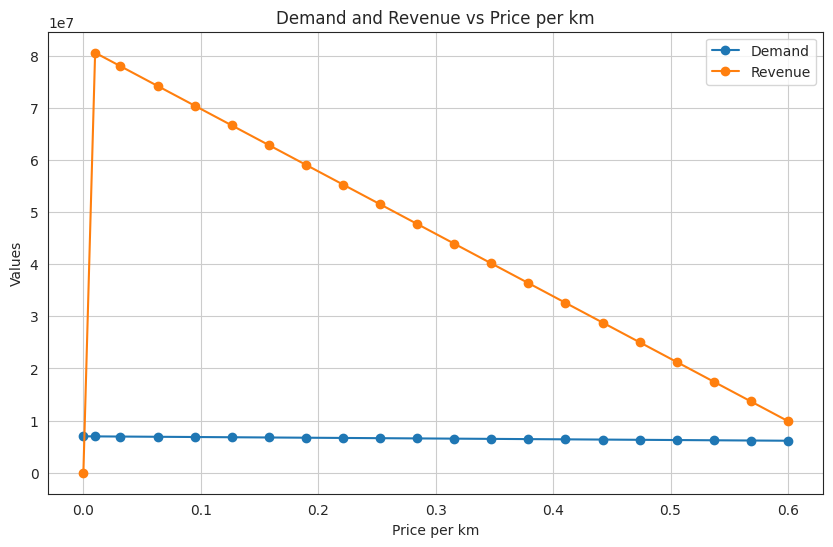

In [13]:

# Generating a set of scenarios that vary price_per_km across its range
price_per_km_values = list(np.linspace(0, 0.6, 20))  # Assuming you want to explore the range in increments of 0.01
price_per_km_values.append(0.01)

scenarios = []

for price in price_per_km_values:
    scenarios.append(Scenario(f"price_{price}", **{
        'trips': 28.5,
        'km': 1417,
        'week_ov': 40.8,
        'weekend_ov': 17.75,
        'non_ov': 7.15,
        'pop': 17375617,
        'students': 292600,
        'international_students': 83817,
        'free_transit': 0,
        'free_transit_students': 0,
        'capacity': 245266,
        'traffic_participation': 82.6,
        'car_trips_per_person_per_day': 0.96,
        'distance_per_car_trip': 18.16,
        'car_C02_emissions': 17600,
        'price_per_km': price
    }))

# Running experiments using these scenarios
with MultiprocessingEvaluator(model_rail) as evaluator:
    results_varied_price = evaluator.perform_experiments(scenarios=scenarios, policies=policies,
                                                         uncertainty_sampling=Samplers.SOBOL)

# results_varied_price[0]

import pandas as pd
import matplotlib.pyplot as plt

# Extract experiments and outcomes
experiments, outcomes = results_varied_price

# Convert experiments to dataframe
experiments_df = pd.DataFrame(experiments)

# Extract price_per_km and corresponding demand and revenue
data = {
    'price_per_km': experiments_df['price_per_km'],
    'demand': outcomes['demand'],
    'revenue': outcomes['revenue']
}

# Convert to dataframe
plot_df = pd.DataFrame(data)

# Group by price_per_km and calculate mean demand and revenue (in case of multiple experiments per price point)
grouped = plot_df.groupby('price_per_km').mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(grouped['price_per_km'], grouped['demand'], label='Demand', marker='o')
plt.plot(grouped['price_per_km'], grouped['revenue'], label='Revenue', marker='o')

plt.xlabel('Price per km')
plt.ylabel('Values')
plt.title('Demand and Revenue vs Price per km')
plt.legend()
plt.grid(True)
plt.show()



[MainProcess/INFO] pool started with 2 workers
[MainProcess/INFO] performing 20 scenarios * 512 policies * 1 model(s) = 10240 experiments
100%|██████████████████████████████████| 10240/10240 [00:07<00:00, 1321.31it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


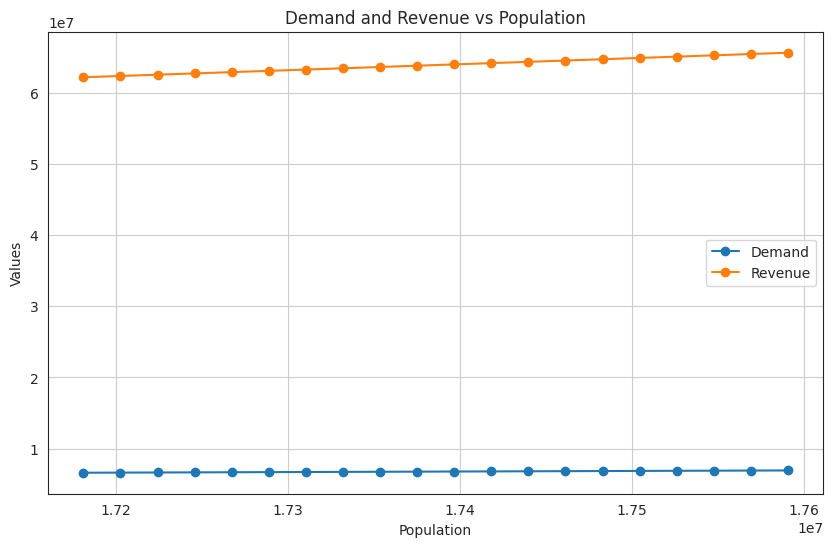

In [14]:

# Generating a set of scenarios that vary price_per_km across its range
pop_values = list(np.linspace(17181084, 17590672, 20))  # Assuming you want to explore the range in increments of 0.01

scenarios = []

for pop in pop_values:
    scenarios.append(Scenario(f"pop_{pop}", **{
        'trips': 28.5,
        'km': 1417,
        'week_ov': 40.8,
        'weekend_ov': 17.75,
        'non_ov': 7.15,
        'pop': pop,
        'students': 292600,
        'international_students': 83817,
        'free_transit': 0,
        'free_transit_students': 0,
        'capacity': 245266,
        'traffic_participation': 82.6,
        'car_trips_per_person_per_day': 0.96,
        'distance_per_car_trip': 18.16,
        'car_C02_emissions': 17600,
        'price_per_km': 0.15
    }))

# Running experiments using these scenarios
with MultiprocessingEvaluator(model_rail) as evaluator:
    results_varied_pop = evaluator.perform_experiments(scenarios=scenarios, policies=policies,
                                                         uncertainty_sampling=Samplers.SOBOL)

# results_varied_price[0]

import pandas as pd
import matplotlib.pyplot as plt

# Extract experiments and outcomes
experiments, outcomes = results_varied_pop

# Convert experiments to dataframe
experiments_df = pd.DataFrame(experiments)

# Extract price_per_km and corresponding demand and revenue
data = {
    'pop': experiments_df['pop'],
    'demand': outcomes['demand'],
    'revenue': outcomes['revenue']
}

# Convert to dataframe
plot_df = pd.DataFrame(data)

# Group by price_per_km and calculate mean demand and revenue (in case of multiple experiments per price point)
grouped = plot_df.groupby('pop').mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(grouped['pop'], grouped['demand'], label='Demand', marker='o')
plt.plot(grouped['pop'], grouped['revenue'], label='Revenue', marker='o')

plt.xlabel('Population')
plt.ylabel('Values')
plt.title('Demand and Revenue vs Population')
plt.legend()
plt.grid(True)
plt.show()



[MainProcess/INFO] pool started with 2 workers
[MainProcess/INFO] performing 20 scenarios * 512 policies * 1 model(s) = 10240 experiments
100%|██████████████████████████████████| 10240/10240 [00:09<00:00, 1136.54it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


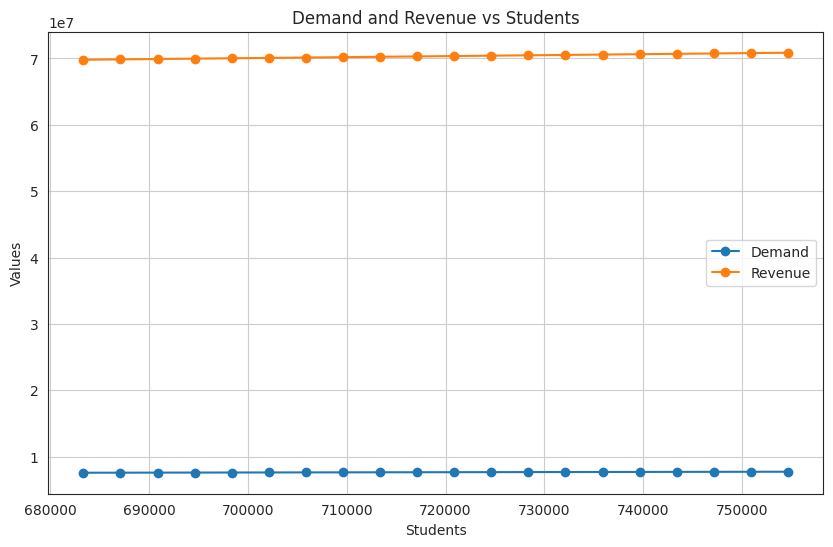

In [15]:

# Generating a set of scenarios that vary price_per_km across its range
students_values = list(np.linspace(683350, 754650, 20))  # Assuming you want to explore the range in increments of 0.01

scenarios = []

for students in students_values:
    scenarios.append(Scenario(f"students_{students}", **{
        'trips': 28.5,
        'km': 1417,
        'week_ov': 40.8,
        'weekend_ov': 17.75,
        'non_ov': 7.15,
        'pop': 17375617,
        'students': students,
        'international_students': 83817,
        'free_transit': 0,
        'free_transit_students': 0,
        'capacity': 245266,
        'traffic_participation': 82.6,
        'car_trips_per_person_per_day': 0.96,
        'distance_per_car_trip': 18.16,
        'car_C02_emissions': 17600,
        'price_per_km': 0.15
    }))

# Running experiments using these scenarios
with MultiprocessingEvaluator(model_rail) as evaluator:
    results_varied_pop = evaluator.perform_experiments(scenarios=scenarios, policies=policies,
                                                         uncertainty_sampling=Samplers.SOBOL)

# results_varied_price[0]

import pandas as pd
import matplotlib.pyplot as plt

# Extract experiments and outcomes
experiments, outcomes = results_varied_pop

# Convert experiments to dataframe
experiments_df = pd.DataFrame(experiments)

# Extract price_per_km and corresponding demand and revenue
data = {
    'students': experiments_df['students'],
    'demand': outcomes['demand'],
    'revenue': outcomes['revenue']
}

# Convert to dataframe
plot_df = pd.DataFrame(data)

# Group by students and calculate mean demand and revenue (in case of multiple experiments per price point)
grouped = plot_df.groupby('students').mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(grouped['students'], grouped['demand'], label='Demand', marker='o')
plt.plot(grouped['students'], grouped['revenue'], label='Revenue', marker='o')

plt.xlabel('Students')
plt.ylabel('Values')
plt.title('Demand and Revenue vs Students')
plt.legend()
plt.grid(True)
plt.show()



<Figure size 1500x600 with 0 Axes>

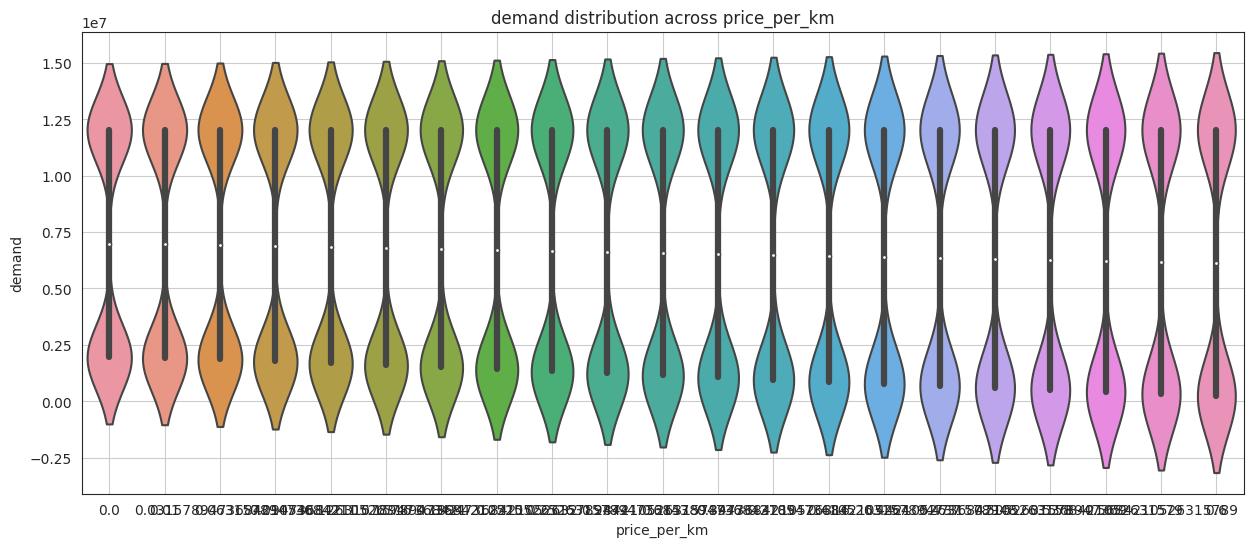

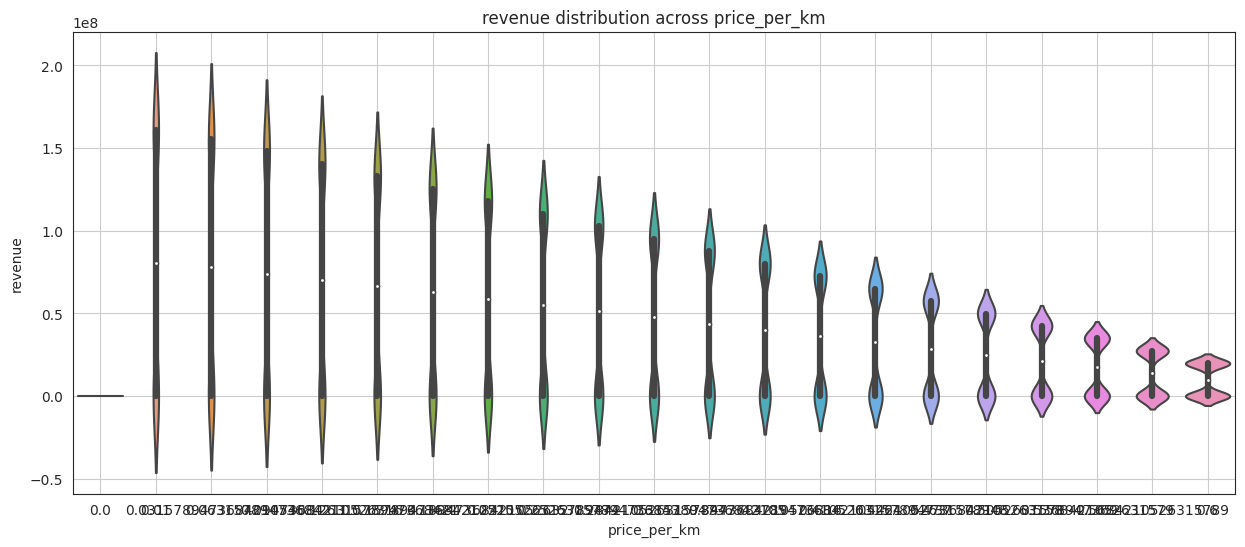

In [16]:
import seaborn as sns

def plot_violin(dataframe, x_col, y_cols):
    """
    Plots a violin plot for each y_col against x_col.

    Parameters:
    - dataframe: A pandas DataFrame containing the data.
    - x_col: The column name in dataframe for the x-axis.
    - y_cols: A list of column names in dataframe for the y-axis.
    """
    plt.figure(figsize=(15, 6))

    for y_col in y_cols:
        plt.figure(figsize=(15, 6))
        sns.violinplot(x=x_col, y=y_col, data=dataframe)
        plt.title(f'{y_col} distribution across {x_col}')
        plt.grid(True)
        plt.show()

# You would use it like this after running your experiments:
# plot_violin(experiments_df, 'price_per_km', ['demand', 'revenue'])

# plot_violin(experiments_df, 'price_per_km', ['demand', 'revenue'])

# Merge experiments and outcomes into a single dataframe
experiments_df = pd.DataFrame(results_varied_price[0])
outcomes_df = pd.DataFrame(results_varied_price[1])

# Concatenate the dataframes
complete_df = pd.concat([experiments_df, outcomes_df], axis=1)

# Try plotting again using the merged dataframe
plot_violin(complete_df, 'price_per_km', ['demand', 'revenue'])



In [17]:
from ema_workbench import (Model, RealParameter, ScalarOutcome, SequentialEvaluator, Policy, perform_experiments)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench import MultiprocessingEvaluator, Samplers
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from numpy.random import RandomState
import math

model_rail.outcomes = [ScalarOutcome('demand', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('revenue', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('shortage', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('additional_trains', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('CO2_reduction', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('net_CO2_emissions', kind=ScalarOutcome.MINIMIZE)]

# Optimize
convergence_metrics = [EpsilonProgress()]

epsilons = [.005, .005, .005, .005, .005, .005]

with MultiprocessingEvaluator(model_rail) as evaluator:
    results, convergence = evaluator.optimize(nfe=5000, searchover='levers', epsilons=epsilons, reference=baseline_scenario[0],
                                              convergence=convergence_metrics)

results


[MainProcess/INFO] pool started with 2 workers
100%|█████████████████████████████████████| 5000/5000 [00:09<00:00, 530.24it/s]
[MainProcess/INFO] optimization completed, found 4 solutions
[MainProcess/INFO] terminating pool


,free_transit,free_transit_students,capacity,demand,revenue,shortage,additional_trains,CO2_reduction,net_CO2_emissions
0,0,1,245269.597133,1.530186e+06,1.272636e+08,0.0,0,125979.402637,15985.472158
1,0,0,245274.934294,1.481974e+06,1.278880e+08,0.0,0,122010.121508,16036.341703
2,1,0,245275.944537,1.200290e+07,0.000000e+00,9550138.0,2957,988191.999792,4935.521019
3,1,1,245275.994736,1.206469e+07,0.000000e+00,9611927.0,2976,993279.059297,4870.326241


In [18]:
def plot_kde(dataframe, x_col, y_cols):
    """
    Plots a KDE plot for each y_col against x_col.

    Parameters:
    - dataframe: A pandas DataFrame containing the data.
    - x_col: The column name in dataframe for the x-axis.
    - y_cols: A list of column names in dataframe for the y-axis.
    """
    plt.figure(figsize=(15, 8))

    for y_col in y_cols:
        sns.kdeplot(x=dataframe[x_col], y=dataframe[y_col], cmap="Blues", fill=True, label=y_col)

    plt.title(f'KDE plot for {", ".join(y_cols)} against {x_col}')
    plt.grid(True)
    plt.legend()
    plt.show()

# You would use this function similarly:
# plot_kde_final(complete_df, 'price_per_km', ['demand', 'revenue'])


# You would use this function similarly:
# plot_kde_updated(complete_df, 'price_per_km', ['demand', 'revenue'])



# plot_kde(complete_df, 'price_per_km', ['demand', 'revenue'])




In [ ]:
from ema_workbench import (Model, RealParameter, ScalarOutcome, SequentialEvaluator, Policy, perform_experiments)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench import MultiprocessingEvaluator, Samplers
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from numpy.random import RandomState
import math

model_rail.outcomes = [ScalarOutcome('demand', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('revenue', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('shortage', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('additional_trains', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('CO2_reduction', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('net_CO2_emissions', kind=ScalarOutcome.MINIMIZE)]

# Optimize
convergence_metrics = [EpsilonProgress()]

epsilons = [.005, .005, .005, .005, .005, .005]

with MultiprocessingEvaluator(model_rail) as evaluator:
    results, convergence = evaluator.optimize(nfe=5000, searchover='levers', epsilons=epsilons, reference=baseline_scenario[0],
                                              convergence=convergence_metrics)

results

[MainProcess/INFO] pool started with 2 workers
 50%|██████████████████▌                  | 2500/5000 [00:04<00:04, 603.82it/s]